In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle
import joblib

In [18]:
data = pd.read_csv("../data/heart.csv")
data.shape

(1000, 14)

In [19]:
data.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [20]:
y = data["target"]
X = data.drop(columns=['patientid','target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [21]:
len(X_train), len(X_test)

(800, 200)

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
X_train.shape

(800, 12)

In [24]:
scaler.mean_

array([4.9766250e+01, 7.6875000e-01, 1.0075000e+00, 1.5193750e+02,
       3.1404625e+02, 3.1250000e-01, 7.5000000e-01, 1.4558625e+02,
       5.0875000e-01, 2.7481250e+00, 1.5600000e+00, 1.2412500e+00])

In [25]:
X_train[:, 0].min(), X_train[:, 0].max(), X_train[:, 2].min(), X_train[:, 2].max()

(-1.6725143415733175,
 1.6987823617198097,
 -1.0532897487880573,
 2.08305689772725)

In [26]:
X_train[0]

array([ 0.40645196, -1.82327297, -1.05328975,  0.93522777,  1.53631292,
       -0.67419986,  0.32547228,  1.35413438, -1.01765584, -0.49016407,
        1.43899306,  1.79450419])

In [27]:
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[ 92   3]
 [  2 103]]


Accuracy of Random Forest: 97.5 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        95
           1       0.97      0.98      0.98       105

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



In [28]:
from sklearn.model_selection import cross_val_score
val_score = cross_val_score(estimator=rf, X = X_train, y=y_train, cv=10)
print("Model Accuracy Score: {:.2f} %".format(val_score.mean()*100))
print("Std. Dev: {:.2f} %".format(val_score.std()*100))

Model Accuracy Score: 96.37 %
Std. Dev: 2.12 %


In [29]:
from sklearn.model_selection import GridSearchCV
# Define the Random Forest model
rf = RandomForestClassifier(random_state=12)

# Define the hyperparameters grid for tuning
param_grid = {
    'n_estimators': [10, 20, 50, 100],   # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required at each leaf node
}

# Perform Grid Search with 10-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and best score found
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print best parameters and best score
print("Best Parameters:", best_params)
print("Best Score (accuracy):", best_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
Best Score (accuracy): 0.9737500000000001


In [30]:
# Train the model with best parameters
best_rf = RandomForestClassifier(**best_params, random_state=12)
best_rf.fit(X_train, y_train)

# Make predictions with the best model
best_rf_predicted = best_rf.predict(X_test)

# Evaluate the best model
best_rf_conf_matrix = confusion_matrix(y_test, best_rf_predicted)
best_rf_acc_score = accuracy_score(y_test, best_rf_predicted)

# Print confusion matrix and accuracy
print("Confusion Matrix:")
print(best_rf_conf_matrix)
print("\nAccuracy of Random Forest (after hyperparameter tuning):", best_rf_acc_score * 100, '\n')
print("Classification Report:")
print(classification_report(y_test, best_rf_predicted))

Confusion Matrix:
[[ 93   2]
 [  0 105]]

Accuracy of Random Forest (after hyperparameter tuning): 99.0 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        95
           1       0.98      1.00      0.99       105

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



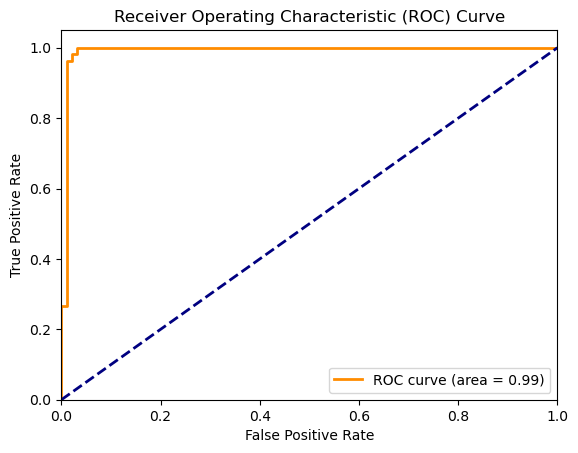

In [18]:
# Compute predicted probabilities
y_pred_proba = rf.predict_proba(X_test)[:,1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [20]:
rf_predicted

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1], dtype=int64)

In [21]:
rf_predict_proba = rf.predict_proba(X_test)
rf_predict_proba.shape

(200, 2)

In [22]:
rf_predict_probability = rf_predict_proba[:,1]
rf_predict_probability

array([0.77258218, 0.91474373, 0.71891092, 0.18199333, 0.95937674,
       0.02338862, 1.        , 0.39190585, 0.9864953 , 0.98181818,
       0.88619932, 0.83987039, 0.01955714, 0.92021266, 0.05185241,
       0.90599401, 0.99388632, 0.99462817, 0.20384827, 0.02338862,
       0.2009448 , 0.36795343, 0.11675942, 0.97938867, 0.75366549,
       0.02105424, 0.12778936, 0.83774339, 0.98280566, 0.01841803,
       0.17928916, 0.3963181 , 0.98126897, 0.99564858, 0.90759887,
       0.8231685 , 0.97328185, 0.0777008 , 0.0303685 , 0.6922285 ,
       0.12352712, 0.29989445, 0.98468089, 0.36887694, 0.9670546 ,
       0.98126897, 0.01632379, 0.15107399, 0.06908463, 0.9983871 ,
       0.01458656, 0.07884528, 0.94667582, 0.97919601, 0.32712332,
       0.96207966, 0.98178525, 0.03811701, 0.95244852, 0.95506991,
       0.99564858, 0.01249232, 0.86844186, 0.96792582, 0.0113461 ,
       0.99047619, 0.98948661, 0.01632379, 0.96394009, 0.03091987,
       0.39107891, 0.02769677, 0.52747688, 0.06957941, 0.02152

In [23]:
rf_predict_probability.shape

(200,)

In [25]:
# save the model to disk
filename = '../saved_models/random_forest_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [26]:
# save the scaler to disk
scaler_filename = "../saved_models/random_forest_model_scaler"
joblib.dump(scaler, scaler_filename) 

['../saved_models/random_forest_model_scaler']

# Front End

In [2]:
# Load the scaler
scaler_filename = "../saved_models/random_forest_model_scaler"
scaler = joblib.load(scaler_filename)

In [3]:
# load the model from disk
filename = '../saved_models/random_forest_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [4]:
# Prediction - Based on FE values
features_values = np.array([53, 1, 2, 171, 0, 0, 1, 147, 0, 5.3, 3, 3]).reshape(1, -1)

In [5]:
features_values.shape

(1, 12)

In [6]:
scaled_features_values = scaler.transform(features_values)
scaled_features_values.shape

C:\Users\divya\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(1, 12)

In [7]:
fe_model_output = loaded_model.predict(scaled_features_values)
fe_model_output.shape

(1,)

In [9]:
fe_model_proba_output = loaded_model.predict_proba(scaled_features_values)
fe_model_proba_output.shape

(1, 2)

In [10]:
fe_predict_probability = fe_model_proba_output[:,1]
fe_predict_probability

array([0.95946374])